In [33]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from nnsight import LanguageModel
import matplotlib.pyplot as plt
import pandas as pd
import os
from huggingface_hub import login
import pickle
from scipy.fft import fft, fftfreq
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import json
import itertools
from matplotlib.patches import Wedge
COL_WIDTH = 3.25
TWO_COL_WIDTH = 6.75

# Load Model

In [34]:
# Load model# Set the token as an environment variable
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
full_model_name = 'EleutherAI/gpt-j-6B' #'EleutherAI/pythia-6.9b'## # #'google/gemma-2-9b'#'##
MODEL_NAME = full_model_name.split('/')[-1]
model = LanguageModel(full_model_name, device_map=device, torch_dtype=torch.bfloat16, dispatch=True)
remote = False
NLAYERS = model.config.num_hidden_layers
datapath = '../number-helix/data'
dataadditionpath = '../number-helix/data_addition'

Some weights of the model checkpoint at EleutherAI/gpt-j-6B were not used when initializing GPTJForCausalLM: ['transformer.h.0.attn.bias', 'transformer.h.0.attn.masked_bias', 'transformer.h.1.attn.bias', 'transformer.h.1.attn.masked_bias', 'transformer.h.10.attn.bias', 'transformer.h.10.attn.masked_bias', 'transformer.h.11.attn.bias', 'transformer.h.11.attn.masked_bias', 'transformer.h.12.attn.bias', 'transformer.h.12.attn.masked_bias', 'transformer.h.13.attn.bias', 'transformer.h.13.attn.masked_bias', 'transformer.h.14.attn.bias', 'transformer.h.14.attn.masked_bias', 'transformer.h.15.attn.bias', 'transformer.h.15.attn.masked_bias', 'transformer.h.16.attn.bias', 'transformer.h.16.attn.masked_bias', 'transformer.h.17.attn.bias', 'transformer.h.17.attn.masked_bias', 'transformer.h.18.attn.bias', 'transformer.h.18.attn.masked_bias', 'transformer.h.19.attn.bias', 'transformer.h.19.attn.masked_bias', 'transformer.h.2.attn.bias', 'transformer.h.2.attn.masked_bias', 'transformer.h.20.attn.bi

# Figure 2


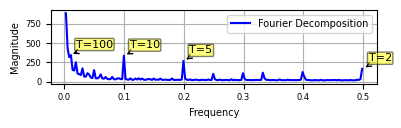

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71.
 72. 73. 74. 75. 76. 77. 78. 79. 80. 81. 82. 83. 84. 85. 86. 87. 88. 89.
 90. 91. 92. 93. 94. 95. 96. 97. 98. 99.]


In [38]:
plt.rcParams.update({
    'font.size': 8,               # Default text size
    'axes.titlesize': 7,          # Title size for axes
    'axes.labelsize': 7,          # Axis label size
    'xtick.labelsize': 6,         # X-axis tick label size
    'ytick.labelsize': 6,         # Y-axis tick label size
    'legend.fontsize': 7,         # Legend font size
    'figure.titlesize': 10,        # Overall figure title size
})
def get_nums_hss(mina = 0,maxa = 99):
    nums = np.linspace(mina, maxa, maxa-mina+1)
    tokens = torch.tensor(model.tokenizer([f'{int(num)}' for num in nums])['input_ids'])
    activations = []
    with torch.no_grad():
        with model.trace(validate=False,remote=remote) as tracer:
            with tracer.invoke(tokens, scan=False):
                for layer in range(NLAYERS):
                    activations.append(model.transformer.h[layer].inputs[1]['hidden_states'][:,-1].save())
    act = torch.stack(activations).detach().cpu()
    return nums, act

def ff(mina = 0, maxa = 500, layer = 0):
    
    nums, hss = get_nums_hss(mina, maxa)
    hss_np = hss[layer].float().cpu().numpy()
    hss_centered = hss_np# - np.mean(hss_np, axis=0, keepdims=True)
    # Apply Hamming window
    window = np.hamming(hss_np.shape[0])[:, np.newaxis]
    fft_result = fft(hss_centered, axis=0)
    # Get frequencies
    n_samples = hss_np.shape[0]
    freqs = fftfreq(n_samples, d=1)  # d=1 since numbers are 1 unit apart
    # Calculate magnitude spectrum
    magnitude_spectrum = np.abs(fft_result)**2
    # Average across hidden dimensions to get overall frequency importance
    avg_magnitude = np.mean(magnitude_spectrum, axis=1)
    # Plot only positive frequencies (first half)
    positive_freq_mask = freqs > 0
    plt.figure(figsize=(1.25*COL_WIDTH, 1.25*0.325*COL_WIDTH))
    plt.plot(freqs[positive_freq_mask], avg_magnitude[positive_freq_mask],label = f'Fourier Decomposition', color = 'b')
    plt.xlabel('Frequency')
    plt.ylabel('Magnitude')
    plt.xticks()
    plt.yticks()
    
    # Label specific periods
    periods_to_label = [2, 5, 10, 100]
    for period in periods_to_label:
        freq = 1/period
        # Find the closest frequency in our data
        idx = np.argmin(np.abs(freqs[positive_freq_mask] - freq))
        mag = avg_magnitude[positive_freq_mask][idx]
        plt.annotate(f'T={period}', 
                    xy=(freq, mag),
                    xytext=(4, 4),
                    textcoords='offset points',
                    ha='left',
                    va='bottom',
                    bbox=dict(boxstyle='round,pad=0.1', fc='yellow', alpha=0.5),
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    #plt.savefig(f'paper_figures/figure_2/fourier_{MODEL_NAME}.pdf', dpi =300, bbox_inches = 'tight')
    plt.show()

ff(mina = 0, maxa = 360, layer = 1)


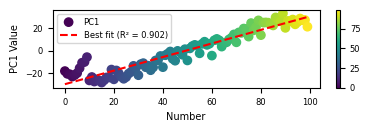

In [39]:
plt.rcParams.update({
    'font.size': 10,               # Default text size
    'axes.titlesize': 7,          # Title size for axes
    'axes.labelsize': 7,          # Axis label size
    'xtick.labelsize': 6,         # X-axis tick label size
    'ytick.labelsize': 6,         # Y-axis tick label size
    'legend.fontsize': 6,         # Legend font size
    'figure.titlesize': 10,        # Overall figure title size
})

def get_pc1(mina, maxa, skip0, layer):
    nums, hss = get_nums_hss(mina, maxa)
    hs = hss[layer].cpu().float().numpy()
    # Perform PCA
    
    # Scale the data
    scaler = StandardScaler()
    hs_scaled = scaler.fit_transform(hs)
    
    # Get first principal component
    pca = PCA(n_components=1)
    pc1_vals = pca.fit_transform(hs_scaled).flatten()
    
    # Print variance explained by PC1
    
    # Create plot
    plt.figure(figsize=(1.25*COL_WIDTH, 1.25*0.35*COL_WIDTH))
    
    # Create scatter plot colored by number value
    scatter = plt.scatter(nums, pc1_vals, c=nums, cmap='viridis', label = 'PC1')
    
    # Calculate line of best fit
    slope, intercept = np.polyfit(nums, pc1_vals, 1)
    line_x = nums
    line_y = slope * line_x + intercept
    
    # Calculate R^2
    r_squared = np.corrcoef(nums, pc1_vals)[0,1]**2
    
    # Plot line of best fit
    plt.plot(line_x, line_y, 'r--', label=f'Best fit (R² = {r_squared:.3f})')
    
    # Add colorbar
    plt.colorbar(scatter)
    
    plt.xlabel('Number')
    plt.ylabel('PC1 Value')
    
    plt.legend()
    plt.tight_layout()
    # Create directory if it doesn't exist
    # Save figure with informative filename
    # plt.savefig(f'paper_figures/figure_2/pc1_layer{layer-1}_range{mina}-{maxa}_skip0={skip0}_{MODEL_NAME}.pdf', 
    #             bbox_inches='tight', dpi = 300)
    plt.show()

get_pc1(mina = 0, maxa = 99, skip0 = False, layer = 1)

# Figure 3
For results on fitting the helix on the 'a' token in a+b, see helix_fitting.ipynb

In [40]:
def get_helix(helix_type, layer):
    save_dir = f'{datapath}/helix_fit/trained_fit'
    save_path = f"{save_dir}/{helix_type}/{helix_type}_fit_layer{layer}_{MODEL_NAME}.pkl"
    with open(save_path, 'rb') as f:
        data = pickle.load(f)
    return torch.tensor(data['A_map'][:-1]).float(), get_feature_names()[:-1]

def get_helix_ablation(helix_type, layer):
    helix_abla, _ = get_helix(helix_type, layer)
    helix_abla = np.linalg.pinv(helix_abla).T
    return helix_abla # no need to ablate the bias direction

def get_feature_names(bases = [2,5,10,100]):
    variables = ['a']
    feature_names = []
    for i in range(len(variables)):
        for base in bases:
            feature_names.extend([f'cos({variables[i]}|T = {base})', f'sin({variables[i]}|T = {base})'])
        feature_names.append(variables[i])
    feature_names.append('1')
    return feature_names # All features

def get_helix_coords(layer):
    a,_, _, hss = get_nums_hss(target = 'a')
    hss = hss[:,layer].float()
    # Create random hidden states with same shape as hss
    #hss = torch.randn_like(hss)
    feature_names = get_feature_names()
    helix_comps = get_helix_ablation('helix_a_[2, 5, 10, 100]', layer)
    # Get pseudo-inverse of helix components (9,4096) -> (4096,9)mponents
    helix_coords = hss @ helix_comps.T # (100,9)
    return a, helix_coords, feature_names


def get_nums_hss(target, mina = 0,maxa = 99, sample = True):
    suffix = '_FULL' if not sample else ''
    save_path = f'{datapath}/helix_hss/{target}_helix_data_{mina}_{maxa}{suffix}_{MODEL_NAME}.pt'
    obj = torch.load(save_path, weights_only=True)
    a,b,a_b, hss = obj['a'], obj['b'], obj['a+b'], obj['hidden_states']
    return a,b,a_b, hss

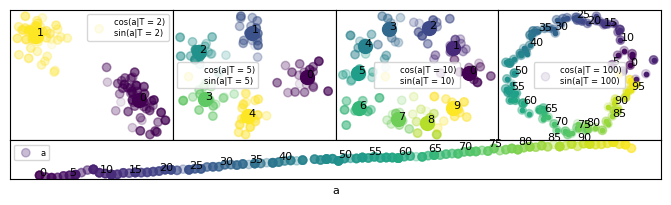

In [41]:
plt.rcParams.update({
    'font.size': 8,               # Default text size
    'axes.titlesize': 8,          # Title size for axes
    'axes.labelsize': 8,          # Axis label size
    'xtick.labelsize': 8,         # X-axis tick label size
    'ytick.labelsize': 8,         # Y-axis tick label size
    'legend.fontsize': 6,         # Legend font size
    'figure.titlesize': 10,        # Overall figure title size
})


def plot_helix_coords(layer):
    a, helix_coords, feature_names = get_helix_coords(layer)
    
    periods = [2, 5, 10, 100]
    fig = plt.figure(figsize=(6.75, 2.1))
    gs = fig.add_gridspec(2, 4, height_ratios=[1, 0.3], hspace=0, wspace=0)
    
    # First 4 subplots showing pairs of dimensions
    for i, period in enumerate(periods):
        ax = fig.add_subplot(gs[0, i])
        
        # Scatter all points colored by remainder
        remainders = a % period
        scatter = ax.scatter(helix_coords[:,i*2], helix_coords[:,i*2+1], 
                           c=remainders, cmap='viridis', alpha=0.1, label=f'{feature_names[i*2]}\n{feature_names[i*2+1]}')
        
        # Calculate and plot means for each remainder value
        means = {}
        for rem in range(period):
            mask = remainders == rem
            if mask.any():
                mean_x = helix_coords[mask,i*2].mean()
                mean_y = helix_coords[mask,i*2+1].mean()
                means[rem] = (mean_x, mean_y)
                s = 100 if period!=100 else 10
                ax.scatter(mean_x, mean_y, c=[plt.cm.viridis(rem/(period-1))], s=s)
                
                # Only annotate every 5 points for period 100, all points otherwise
                if period != 100 or rem % 5 == 0:
                    color = 'black'
                    ax.annotate(str(rem), (mean_x, mean_y), color=color)
        
        ax.set_xticks([])
        ax.set_yticks([])
        ax.legend()
    
    # Final subplot showing a vs last coordinate
    ax = fig.add_subplot(gs[1, :])
    ax.scatter(a, helix_coords[:,-1], c=a, cmap='viridis', alpha=0.3, label='a')
    
    # Annotate every 5th point
    for val in range(0, 100, 5):
        mask = a == val
        if mask.any():
            x = a[mask][0]
            y = helix_coords[mask,-1][0]
            color = 'black'
            ax.annotate(str(val), (x, y*1.2), color=color)
            
    ax.set_xlabel('a')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.legend()
    
    plt.tight_layout()
    #plt.savefig('paper_figures/figure_3/fig3_helix_fit_layer0_gpt-j-6B.pdf', dpi = 300)
    plt.show()

plot_helix_coords(1)

# Figure 3
For intervention results on fitting the 'a' token for a+b, see helix_fitting.ipynb

In [42]:

def load_intervention_results(target='a'):
    path = f'{datapath}/helix_fit/intervention_results_{target}_{MODEL_NAME}.json'
    with open(path, 'r') as f:
        results = json.load(f)
    # Convert to dict with patch_type -> metric -> layer list structure
    output = {}
    for patch_type, layer_results in results.items():
        output[patch_type] = {}
        # Initialize metric lists
        for metric in layer_results[0].keys():
            output[patch_type][metric] = []
        # Fill in values for each layer
        for layer_metrics in layer_results:
            for metric, value in layer_metrics.items():
                output[patch_type][metric].append(value)
    return output

def get_bases_perms():
    bases_list = [2, 5, 10, 100]
    all_perms = []
    # Add all lengths of combinations
    for length in range(1, len(bases_list) + 1):
        combs = list(itertools.combinations(bases_list, length))
        all_perms.extend(combs)
    # Convert tuples to lists
    all_perms = [list(p) for p in all_perms]
    return all_perms

def get_all_param(target, fit_type, num_params):
    assert fit_type in ['helix', 'poly', 'circle', 'pca']
    assert num_params in [3,5,7,9]
    if fit_type == 'poly':
        return [f'poly_{target}_{num_params}']
    if fit_type == 'pca':
        return [f'pca_{num_params}']
    bases = get_bases_perms()
    params = []
    for base in bases:
        if len(base)*2 +1 == num_params:
            params.append(f'{fit_type}_{target}_{base}')
    return params

def get_best(num_params, metric = 'logit_diff', target = 'a'):
    data = load_intervention_results(target)
    fit_types = ['pca', 'helix', 'circle', 'poly']
    results = {}
    for fit_type in fit_types:
        best = float('-inf')
        params = get_all_param(target, fit_type, num_params)
        for param in params:
            score = np.mean(data[param][metric])
            if score > best:
                results[fit_type] = param
        #print(fit_type, score)
    return results


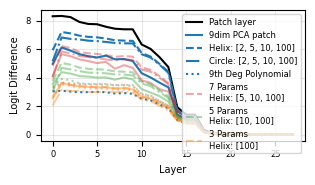

In [43]:
plt.rcParams.update({
    'font.size': 10,               # Default text size
    'axes.titlesize': 7,          # Title size for axes
    'axes.labelsize': 7,          # Axis label size
    'xtick.labelsize': 6,         # X-axis tick label size
    'ytick.labelsize': 6,         # Y-axis tick label size
    'legend.fontsize': 6,         # Legend font size
    'figure.titlesize': 10,        # Overall figure title size
})

def split_helix_type(helix_type):
    if 'pca' in helix_type:
        num = int(helix_type.split('_')[-1])
        return f'{num}dim PCA patch'
    elif 'poly' in helix_type:
        base = int(helix_type.split('_')[-1])
        return f'{base}th Deg Polynomial'
    else:
        bases = eval(helix_type.split('_')[-1])
        type_prefix = 'Helix' if 'helix' in helix_type else 'Circle'
        return f'{type_prefix}: {bases}'

def plot_intervention_results(metric = 'logit_diff', target = 'a'):
    data = load_intervention_results(target)

    plt.figure(figsize=(COL_WIDTH, 1.95))
    plt.plot(data['exchange'][metric], color='k', linestyle='-', label = 'Patch layer')
    toplots = ['pca', 'helix', 'circle', 'poly']
    colors = ['#1f77b4', '#d62728', '#2ca02c', '#ff7f0e']  # Standard matplotlib colors
    linestyles = ['-', '--', '-.', ':']
    for i, num_params in enumerate([9,7,5,3]):
        fits = get_best(num_params)
        for j, toplot in enumerate(toplots):
            best_fit = fits[toplot]
            values = data[best_fit][metric]
            label = split_helix_type(best_fit)
            if num_params == 9:
                plt.plot(values, color=colors[i], linestyle=linestyles[j], 
                    label=label)
            elif toplot == 'helix':
                plt.plot(values, color=colors[i], linestyle=linestyles[j], 
                    label=f'{num_params} Params\n{label}', alpha = 0.4)
            else:
                plt.plot(values, color=colors[i], linestyle=linestyles[j], alpha = 0.4)
    plt.xlabel('Layer')
    metric_map = {'logit_diff': 'Logit Difference'}
    plt.ylabel(metric_map[metric])
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Save figure
    save_dir = 'paper_figures/figure_4'
    os.makedirs(save_dir, exist_ok=True)
    save_path = f'{save_dir}/fig4_helix_intervention_{target}_{MODEL_NAME}.pdf'
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight', dpi = 300)
    plt.show()
    plt.close()

MODEL_NAME = 'gpt-j-6B'#'pythia-6.9b'#'Llama-3.1-8B'#'gpt-j-6B'
plot_intervention_results(metric = 'logit_diff')

# Figure 5- AB Helix
For results fitting the a+b helices on the last token, see ab_helix_fitting.ipynb

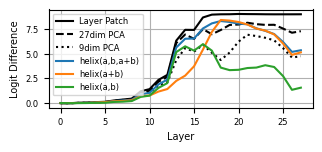

In [44]:
plt.rcParams.update({
    'font.size': 10,               # Default text size
    'axes.titlesize': 7,          # Title size for axes
    'axes.labelsize': 7,          # Axis label size
    'xtick.labelsize': 6,         # X-axis tick label size
    'ytick.labelsize': 6,         # Y-axis tick label size
    'legend.fontsize': 6,         # Legend font size
    'figure.titlesize': 10,        # Overall figure title size
})

mapping = {'helix_a_b':'helix(a,b)', 'helix_ab': 'helix(a+b)', 'helix_a_b_ab': 'helix(a,b,a+b)', 'pca_27': '27dim PCA', 'pca_9': '9dim PCA', 'exchange': 'Layer Patch'}
def plot_all_fits():
    filename = f"{datapath}/ab_meta_fits/ab_fit_metrics_{MODEL_NAME}.pkl"
    # Load saved results
    with open(filename, 'rb') as f:
        data = pickle.load(f)
        metrics_data = data['metrics']
        fit_types = data['fit_types']
    metric = 'logit_diff'
    data = metrics_data[metric][::-1]
    fit_types = fit_types[::-1]
    plt.figure(figsize = (COL_WIDTH,COL_WIDTH/2))
    linestyles = {'pca_9':':', 'pca_27':'--', 'exchange': '-'}
    for i,fit_type in enumerate(fit_types):
        if 'pca' in fit_type or 'exchange' in fit_type:
            plt.plot(list(range(NLAYERS)), 
                data[i],
                ls = linestyles[fit_type],
                color = 'k',
                label=f'{mapping[fit_type]}')
        else:
            plt.plot(list(range(NLAYERS)), 
                    data[i],
                    label=f'{mapping[fit_type]}')
    #plt.plot(list(range(NLAYERS)), metrics_data[metric][-1], color = 'k', label = f'{fit_types[-1]}')
    #plt.title(f'Fitting Answer Hidden States of {MODEL_NAME}\na+b= for '+r'$a,b \in$'+f'[{0}, {99}]')
    plt.xlabel('Layer')
    plt.ylabel('Logit Difference')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    #plt.savefig(f'paper_figures/figure_5/fig5_ab_fits_logit_diff_gpt-j-6B.pdf', dpi = 300, bbox_inches = 'tight')
    plt.show()

plot_all_fits()
        
        

# Fig 6 - attn /mlp patching

See ab_attn_mlp.ipynb for the experimentation behind this plot. In that file, we also present additional results for attenton heads, including activation patching, circuit identification, attention patterns, and initial DE/TE ratio exploration.

In ab_attn_analysis.ipynb, we present helix fitting the outputs attention heads and intervention results, in addition to the categorization in the paper of attention heads into a,b, a+b, and mixed heads.

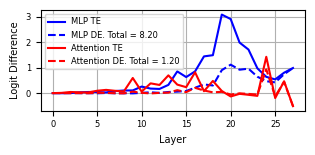

In [45]:
plt.rcParams.update({
    'font.size': 10,               # Default text size
    'axes.titlesize': 7,          # Title size for axes
    'axes.labelsize': 7,          # Axis label size
    'xtick.labelsize': 6,         # X-axis tick label size
    'ytick.labelsize': 6,         # Y-axis tick label size
    'legend.fontsize': 6,         # Legend font size
    'figure.titlesize': 10,        # Overall figure title size
})

def plot_act_patch():
    # Load results from pickle files
    results_df_act = pd.read_pickle(f'{dataadditionpath}/ab_patching/attn_mlp_activation_patching_0_99.pkl')
    results_df_path = pd.read_pickle(f'{dataadditionpath}/ab_patching/attn_mlp_path_patching_0_99.pkl')
    mlp_de, mlp_ie = results_df_path['mlp_logdiff'].sum(), results_df_act['mlp_logdiff'].sum()
    attn_de, attn_ie = results_df_path['attn_logdiff'].sum(), results_df_act['attn_logdiff'].sum()
    # Create the plot
    plt.figure(figsize=(COL_WIDTH,1.65))
    linewidth = 1.5
    plt.plot(results_df_act['layers'], results_df_act['mlp_logdiff'], color='blue', label=f'MLP TE', linewidth = linewidth)
    plt.plot(results_df_path['layers'], results_df_path['mlp_logdiff'], color='blue', label=f'MLP DE. Total = {mlp_de:.2f}', linestyle = '--', linewidth = linewidth)
    plt.plot(results_df_act['layers'], results_df_act['attn_logdiff'], color='red', label=f'Attention TE', linewidth = linewidth)
    plt.plot(results_df_path['layers'], results_df_path['attn_logdiff'], color='red', label=f'Attention DE. Total = {attn_de:.2f}', linestyle = '--', linewidth = linewidth)
    # print(results_df_path['mlp_logdiff'].values)
    # print(results_df_act['mlp_logdiff'].values)
    #plt.title(f'Activation Patching: MLP and Attention Effects by Layer\nTotal DE: {mlp_de+attn_de:.2f}, MLP DE: {mlp_de:.2f}, attn DE: {attn_de:.2f}')
    plt.xlabel('Layer')
    plt.ylabel('Logit Difference')
    plt.legend()
    plt.grid(True)
    
    # Save the figure
    plt.tight_layout()
    #plt.savefig('paper_figures/figure_6/fig6_act_path_patching_mlp_attn.pdf', bbox_inches = 'tight', dpi = 300)
    plt.show()
    plt.close()
    

plot_act_patch() 

# Figure 7 analyzing MLPs

See ab_mlp_analysis.ipynb for the experimentation behind this plot

In [46]:
def read_topk_mlp_patches():
    # Read results from file
    save_dir = f"{dataadditionpath}/ab_mlps"
    results = np.load(f"{save_dir}/topk_mlp_act_patch_results_{MODEL_NAME}.npy")
    return results

def get_intervention_results(helix_type):
    assert helix_type in ['helix_a_b', 'helix_ab', 'helix_a_b_ab'], f"helix_type must be one of ['a_b', 'ab', 'a_b_ab'], got {helix_type}"
    save_dir = f"{dataadditionpath}/ab_mlps"
    save_path = f"{save_dir}/intervention_results_{MODEL_NAME}.pkl"
    with open(save_path, 'rb') as f:
        results = pickle.load(f)
    helix_act = np.zeros((NLAYERS,))
    helix_path = np.zeros((NLAYERS,))
    full_act = np.zeros((NLAYERS,))
    full_path = np.zeros((NLAYERS,))
    for layer in range(NLAYERS):
        helix_act[layer] = results[layer][helix_type]['act_logdiff']
        helix_path[layer] = results[layer][helix_type]['path_logdiff']
        full_act[layer] = results[layer]['full']['act_logdiff']
        full_path[layer] = results[layer]['full']['path_logdiff']
    return helix_act, helix_path, full_act, full_path

def get_topk_mlps(k):
    _,_, full_act, _ = get_intervention_results('helix_a_b')
    layers = list(range(NLAYERS))
    # Sort layers by their full_act values in descending order and get top k
    sorted_layers = [x for _,x in sorted(zip(full_act, layers), reverse=True)]
    return sorted_layers[:k]

def get_mlps_threshold(pct):
    results = read_topk_mlp_patches()
    max_logdiff = max(results)
    threshold = max_logdiff * pct
    # Find first k that exceeds threshold
    k = next(i for i, v in enumerate(results) if v >= threshold)
    return k, sorted(get_topk_mlps(k))

/tmp/ipykernel_876953/3176713785.py:22: RuntimeWarning: divide by zero encountered in divide
  fraction = helix_ab/full_act
/tmp/ipykernel_876953/3176713785.py:23: RuntimeWarning: invalid value encountered in divide
  de_ie = full_path_ab/full_act_ab


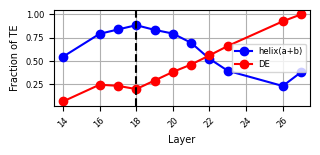

In [47]:
plt.rcParams.update({
    'font.size': 10,               # Default text size
    'axes.titlesize': 7,          # Title size for axes
    'axes.labelsize': 7,          # Axis label size
    'xtick.labelsize': 6,         # X-axis tick label size
    'ytick.labelsize': 6,         # Y-axis tick label size
    'legend.fontsize': 6,         # Legend font size
    'figure.titlesize': 10,        # Overall figure title size
})

def plot_helix_ab_and_de_ie():
    
    # Get circuit MLPs
    thresh = 0.95
    k, circuit_mlps = get_mlps_threshold(thresh)
    
    # Get data for both plots
    helix_a_b, _, full_act, _ = get_intervention_results('helix_a_b')
    helix_all, _, _, _ = get_intervention_results('helix_a_b_ab')
    helix_ab, _, full_act_ab, full_path_ab = get_intervention_results('helix_ab')
    
    fraction = helix_ab/full_act
    de_ie = full_path_ab/full_act_ab
    
    # Filter circuit MLPs by threshold
    circuit_mlps = [mlp for mlp in circuit_mlps if full_act[mlp] > 0.05]
    min_layer = min(circuit_mlps)
    max_layer = max(circuit_mlps)
    
    # Create single plot
    fig, ax = plt.subplots(figsize=(3.25,1.65))
    
    # Plot both ratios
    circuit_fractions = [fraction[i] for i in circuit_mlps]
    circuit_de_ie = [de_ie[i] for i in circuit_mlps]
    
    ax.plot(circuit_mlps, circuit_fractions, color='blue', marker='o', label='helix(a+b)')
    ax.plot(circuit_mlps, circuit_de_ie, color='red', marker='o', label='DE')
    
    ax.axvline(x=18, color='k', linestyle='--')
    ax.set_xlabel('Layer')
    ax.set_ylabel('Fraction of TE')
    ax.legend(loc = 'center right')
    ax.grid(True)
    
    # Set x-axis ticks
    plt.xticks(range(min_layer, max_layer+1, 2), range(min_layer, max_layer+1, 2), rotation=45)
    ax.set_xlim(min_layer-0.5, max_layer+0.5)
    
    plt.tight_layout()
    
    # Save and show
    #plt.savefig(f"paper_figures/figure_7/fig7_mlp_helix_ab_and_de_ie_{MODEL_NAME}.pdf", bbox_inches = 'tight', dpi = 300)
    plt.show()
    plt.close()

plot_helix_ab_and_de_ie()

# Figure 8 neuron preactivations
See neuron_att_patching.ipynb for attribution patching experiments to identify the top k neurons


See neuron_investigations.ipynb for the preactivation fitting experiments

In [48]:
def get_ndf(mina = 0, maxa = 99):
    with open(f'{dataadditionpath}/prepost_acts/neuron_prepostact_results_mina{mina}_maxa{maxa}.pkl', 'rb') as f:
        results = pickle.load(f)
    preacts, postacts, neurondf = results['pre_acts'], results['post_acts'], results['neurondf']
    return preacts, postacts, neurondf

def get_nrmse(idx):
    neurondf = pd.read_pickle(f'{datapath}/all_neuron_fits/results.pkl')['neurondf']
    nrmse = neurondf.loc[idx, 'nrmse']
    return nrmse.item()

def get_formula(idx):
    data = np.load(f'{datapath}/neuron_fits/neuron_{idx}.npz', allow_pickle=True)
    model_data = data['model']
    periods = [2,5,10,100]
    
    # Collect all terms with their amplitudes
    terms = []
    
    # Add cosine terms
    for i, period in enumerate(periods):
        base_idx = i * 3
        
        # a term
        amp_a = model_data.item()['amplitudes'][base_idx]
        offset_a = model_data.item()['offsets'][base_idx]
        terms.append((abs(amp_a), f"{amp_a:.1f}cos(2π/{period:.0f}(a-{offset_a:.1f})"))
        
        # b term
        amp_b = model_data.item()['amplitudes'][base_idx + 1]
        offset_b = model_data.item()['offsets'][base_idx + 1]
        terms.append((abs(amp_b), f"{amp_b:.1f}cos(2π/{period:.0f}(b-{offset_b:.1f})"))
        
        # a+b term
        amp_ab = model_data.item()['amplitudes'][base_idx + 2]
        offset_ab = model_data.item()['offsets'][base_idx + 2]
        terms.append((abs(amp_ab), f"{amp_ab:.1f}cos(2π/{period:.0f}(a+b{'+' if offset_ab < 0 else '-'}{abs(offset_ab):.1f}))"))

    # Add linear terms
    lin_x = model_data.item()['linear_weights'][0]
    lin_y = model_data.item()['linear_weights'][1]
    lin_xy = model_data.item()['linear_weights'][2]
    terms.append((abs(lin_x), f"{lin_x:.2f}a"))
    terms.append((abs(lin_y), f"{lin_y:.2f}b"))
    terms.append((abs(lin_xy), f"{lin_xy:.2f}(a+b)"))
    
    # Add bias
    bias = model_data.item()['bias'][0]

    # Sort by absolute amplitude and extract just the formula strings
    terms.sort(key=lambda x: x[0], reverse=True)
    terms.append((abs(bias), f"{bias:.3f}"))
    formula = [term[1] for term in terms]
    
    return formula

get_formula(10)

['1.31b',
 '1.18a',
 '-0.8cos(2π/2(a+b+0.5))',
 '-0.7cos(2π/100(b--1.9)',
 '-0.4cos(2π/100(a--2.4)',
 '0.34(a+b)',
 '0.2cos(2π/100(a+b+1.7))',
 '0.2cos(2π/10(a--2.8)',
 '-0.2cos(2π/5(b-0.5)',
 '-0.2cos(2π/10(b-0.3)',
 '-0.1cos(2π/2(b-0.6)',
 '-0.1cos(2π/5(a+b-0.1))',
 '0.1cos(2π/10(a+b+0.3))',
 '0.0cos(2π/2(a-0.1)',
 '-0.0cos(2π/5(a--0.0)',
 '4.812']

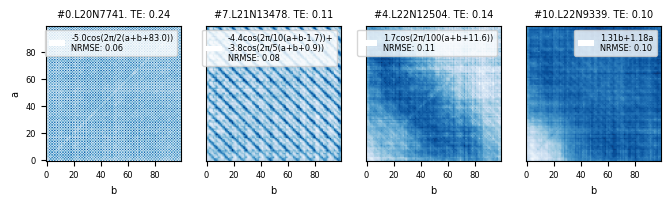

In [49]:
plt.rcParams.update({
    'font.size': 8,               # Default text size
    'axes.titlesize': 7,          # Title size for axes
    'axes.labelsize': 7,          # Axis label size
    'xtick.labelsize': 6,         # X-axis tick label size
    'ytick.labelsize': 6,         # Y-axis tick label size
    'legend.fontsize': 6,         # Legend font size
    'figure.titlesize': 8,        # Overall figure title size
})


def plot_preacts():
    idxs = {0:1,7:2,4:1,10:2} # number of terms
    preacts, postacts, neurondf = get_ndf()
    
    # Create figure with subplots in one row
    fig, axes = plt.subplots(1, len(idxs), figsize=(6.75, 2.05))

    plt.subplots_adjust(wspace = 0)
    
    for i, idx in enumerate(idxs.keys()):
        # Get neuron info
        layer = int(neurondf.iloc[idx]['layer'])
        neuron = int(neurondf.iloc[idx]['neuron_idx']) 
        logit_diff = neurondf.iloc[idx]['logit_difference']
        formula = get_formula(idx)[:idxs[idx]]
        nrmse = get_nrmse(idx)
        if i == 1:
            formula = '+\n'.join(formula)
        else: formula = '+'.join(formula)
        formula+=f'\nNRMSE: {nrmse:.2f}'
        # Plot preactivation
        im = axes[i].imshow(preacts[idx], cmap='Blues', origin='lower')
        #plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)

        # Create proxy artist for legend
        proxy = plt.Rectangle((0, 0), 1, 1, fc='white')  # Invisible rectangle
        axes[i].legend([proxy], [formula], fontsize = 5.86)

        # Add title with neuron info
        axes[i].set_title(f'#{idx}.L{layer}N{neuron}. TE: {logit_diff:.2f}')
        axes[i].set_xlabel('b')
        if i == 0:
            axes[i].set_ylabel('a')
        else:
            axes[i].set_yticks([])
    
    plt.tight_layout()
    #plt.savefig('paper_figures/figure_8/fig8_neuron_fits.pdf', bbox_inches = 'tight', dpi = 300)
    plt.show()
    plt.close()
plot_preacts()

# Figure 9 neuron fitting results

See neuron_fitting_results.ipynb for the experimentation behind this plot

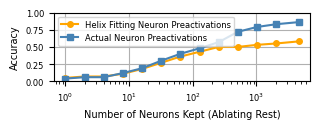

,k,accuracy_fit,accuracy_no_fit,logit_diff_fit,logit_diff_no_fit
0,1,0.05,0.04,7.183437,7.175625
1,2,0.07,0.06,7.083750,7.074687
2,4,0.07,0.06,7.000625,6.992188
3,8,0.11,0.12,6.792188,6.761562
4,16,0.18,0.19,6.411250,6.348750
5,32,0.27,0.30,5.890625,5.793750
6,64,0.36,0.40,5.360000,5.117500
7,128,0.43,0.48,4.680625,4.339375
8,256,0.50,0.57,4.183750,3.645625
9,512,0.50,0.72,3.753125,2.947500


In [50]:
def get_fit_results():
    with open(f'{datapath}/all_neuron_fits/results.pkl', 'rb') as f:
        results = pickle.load(f)
    Npred, ndf, preacts = results['N_predictions'], results['neurondf'], results['preacts']
    return Npred, ndf, preacts

plt.rcParams.update({
    'font.size': 10,               # Default text size
    'axes.titlesize': 7,          # Title size for axes
    'axes.labelsize': 7,          # Axis label size
    'xtick.labelsize': 6,         # X-axis tick label size
    'ytick.labelsize': 6,         # Y-axis tick label size
    'legend.fontsize': 6,         # Legend font size
    'figure.titlesize': 10,        # Overall figure title size
})

def benchmarking_neuron_fits():
    _, ndf, _ = get_fit_results()
    maxk = len(ndf)
    df = pd.read_csv(f'{dataadditionpath}/neuron_fits/fit_neurons_comparison.csv')
    metric = 'accuracy'
    #for metric in metrics:
    plt.figure(figsize=(COL_WIDTH,1.4))
    plt.semilogx(df['k'], df[f'{metric}_fit'], 'o-', markersize=4, label='Helix Fitting Neuron Preactivations', color = 'orange')
    plt.semilogx(df['k'], df[f'{metric}_no_fit'], 's-', markersize=4, label='Actual Neuron Preactivations', color = 'steelblue')
    plt.xlabel('Number of Neurons Kept (Ablating Rest)')
    plt.ylabel('Accuracy')
    plt.ylim(0,1)
    #plt.title(f'Evaluating Neuron Fits for Top 1% Neurons\n(Metric: {metric.replace("_", " ").title()})')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    
    #plt.savefig(f'paper_figures/figure_9/fig9_fit_neurons_comparison_{metric}.pdf', bbox_inches = 'tight', dpi = 300)
    plt.show()
    plt.close()
    
    return df

benchmarking_neuron_fits()

# Fig 10
See neuron_trends.ipynb for the experimentation behind this plot

In [54]:
def get_mlps_threshold(pct):
    results = read_topk_mlp_patches()
    max_logdiff = max(results)
    threshold = max_logdiff * pct
    # Find first k that exceeds threshold
    k = next(i for i, v in enumerate(results) if v >= threshold)
    return k, sorted(get_topk_mlps(k))

def load_path_patch():
    df = pd.read_csv(f'{dataadditionpath}/neuron_path_patching.csv', index_col=False)
    return df
def load_ab_fractions(frac = 1):
    ndf = pd.read_pickle(f'{dataadditionpath}/neuron_fits/neuron_ab_fractions.pkl')
    n = int(len(ndf) * frac)
    return ndf.nlargest(n, 'logit_difference')
def read_topk_mlp_patches():
    # Read results from file
    save_dir = f"{dataadditionpath}/ab_mlps"
    results = np.load(f"{save_dir}/topk_mlp_act_patch_results_{MODEL_NAME}.npy")
    return results

def get_topk_mlps(k):
    _,_, full_act, _ = get_intervention_results('helix_a_b')
    layers = list(range(NLAYERS))
    # Sort layers by their full_act values in descending order and get top k
    sorted_layers = [x for _,x in sorted(zip(full_act, layers), reverse=True)]
    return sorted_layers[:k]

def get_intervention_results(helix_type):
    assert helix_type in ['helix_a_b', 'helix_ab', 'helix_a_b_ab'], f"helix_type must be one of ['a_b', 'ab', 'a_b_ab'], got {helix_type}"
    save_dir = f"{dataadditionpath}/ab_mlps"
    save_path = f"{save_dir}/intervention_results_{MODEL_NAME}.pkl"
    with open(save_path, 'rb') as f:
        results = pickle.load(f)
    helix_act = np.zeros((NLAYERS,))
    helix_path = np.zeros((NLAYERS,))
    full_act = np.zeros((NLAYERS,))
    full_path = np.zeros((NLAYERS,))
    for layer in range(NLAYERS):
        helix_act[layer] = results[layer][helix_type]['act_logdiff']
        helix_path[layer] = results[layer][helix_type]['path_logdiff']
        full_act[layer] = results[layer]['full']['act_logdiff']
        full_path[layer] = results[layer]['full']['path_logdiff']
    return helix_act, helix_path, full_act, full_path

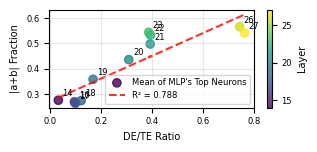

In [55]:
plt.rcParams.update({
    'font.size': 6,               # Default text size
    'axes.titlesize': 7,          # Title size for axes
    'axes.labelsize': 7,          # Axis label size
    'xtick.labelsize': 6,         # X-axis tick label size
    'ytick.labelsize': 6,         # Y-axis tick label size
    'legend.fontsize': 6,         # Legend font size
    'figure.titlesize': 8,        # Overall figure title size
})
def correlation_deie_abhelix_layer():
    pathdf = load_path_patch()#get_path_patch_threshold(0.8)
    pathdf['de_ie'] = pathdf['path_patch']/pathdf['logit_difference']
    ab_df = load_ab_fractions()
    
    # Merge dataframes on layer and neuron_idx
    df = pd.merge(pathdf, ab_df[['layer', 'neuron_idx', 'ab_frac']], 
                 on=['layer', 'neuron_idx'],
                 how='inner')
    
    # Circuit MLP layers
    _, circuit_mlps = get_mlps_threshold(pct = 0.95)
    
    # Calculate means per layer, filtering for circuit MLPs only
    layer_means = df[df['layer'].isin(circuit_mlps)].groupby('layer').agg({
        'de_ie': 'mean',
        'ab_frac': 'mean'
    }).reset_index()
    
    # Create scatter plot
    plt.figure(figsize=(3.25, 1.5))
    
    # Calculate line of best fit
    x = layer_means['de_ie']
    y = layer_means['ab_frac']
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    r_squared = np.corrcoef(x, y)[0,1]**2
    
    # Plot layer means with viridis colormap
    scatter = plt.scatter(x, y, alpha=0.8, 
                         c=layer_means['layer'], 
                         cmap='viridis',
                         label = "Mean of MLP's Top Neurons")
    plt.colorbar(scatter, label='Layer')
    
    # Plot line of best fit
    plt.plot(x, p(x), "r--", alpha=0.8, label =  f'R² = {r_squared:.3f}')
    
    # Add layer annotations
    for _, row in layer_means.iterrows():
        plt.annotate(f"{int(row['layer'])}", 
                    (row['de_ie'], row['ab_frac']),
                    xytext=(3, 3), textcoords='offset points')
    
    plt.xlabel('DE/TE Ratio')
    plt.ylabel('|a+b| Fraction')
    #plt.title('DE/IE Ratio vs A+B Helix Reading by Layer\nFor Circuit MLPs')
    plt.grid(True, alpha=0.3)
    
    # Add R² value
    plt.legend()
    plt.tight_layout()
    # plt.savefig('paper_figures/figure_10/fig10_neuron_dete_helixab.pdf',
    #             bbox_inches='tight',
    #             dpi=300)
    plt.show()
    plt.close()

correlation_deie_abhelix_layer()

### For additional results regarding an investigation into model errors/logit contributions (Appendix F) and path patching results for neurons, see study_logits.ipynb and neuron_path_patching.ipynb respectively